The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0 # training scenes, 60 # test scenes
240


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generating video:  savi_test_voronoi_superquadric_1_scene-0_flows_1-16


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Generating video:  savi_test_voronoi_superquadric_1_scene-0_masks_1-16


CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '576x432', '-pix_fmt', 'rgba', '-r', '8', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', 'figures/savi_test_voronoi_superquadric_1_scene-0_masks_1-16.mp4']' returned non-zero exit status 255.

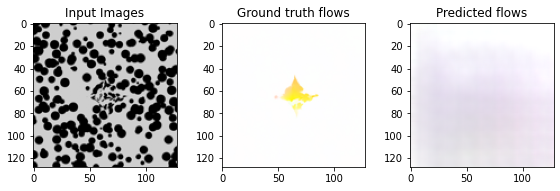

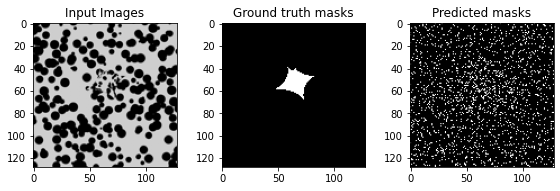

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import sys
sys.path.append("../")
from data import gestalt
from models import SAVi
from torch.utils.data import DataLoader

%load_ext autoreload
%autoreload 2

model = SAVi.SlotAttentionVideo(num_slots=5)

model_checkpoint_dir = "/om2/user/yyf/GestaltVision/saved_models/SAVI/tex=all_shapes=2,3_slots=5"
models = os.listdir(model_checkpoint_dir)
models.sort()

latest = models[-1]
model_chkpt = os.path.join(model_checkpoint_dir, latest)
chkpt = torch.load(model_chkpt, map_location="cpu")
model.load_state_dict(chkpt["model"])

data = DataLoader(gestalt.Gestalt(root_dir="/om2/user/yyf/CommonFate/scenes",
                                top_level=[f"test_{tex}" for tex in ["voronoi", "wave", "noise"]], 
                                  sub_level=[f"superquadric_{i}" for i in [1, 2, 3, 4]],
                                  frames_per_scene=16,
                                  train_split=0,
                                  training=False
                      ), batch_size=1)
data.training = False
model.eval()

print(len(data))

from utils import make_video

def plot_results(inputs, outputs):
    idx = inputs["scene"]
    scene_dir = inputs["scene_dir"]
    frame_idxs = inputs["frame_idxs"]
    
    path_parts = scene_dir[0].split("/")
    tex = path_parts[-3]
    objs = path_parts[-2]
    scene_num = path_parts[-1]

    images = inputs["images"].detach().cpu().squeeze(0).numpy().transpose(0, 2, 3, 1)
    gt_flows = inputs["flows"].detach().cpu().squeeze(0).numpy().transpose(0, 2, 3, 1)
    gt_masks = inputs["masks"].sum(dim=1).detach().cpu().squeeze(0).numpy().transpose(0, 2, 3, 1)
    
    recons = outputs["recon_combined"].detach().cpu().squeeze(0).numpy().transpose(0, 2, 3, 1)
    pred_masks = outputs["masks"].detach().cpu().squeeze(0).numpy()
    
    slots = outputs["recons"].detach().cpu().squeeze(0).numpy()
    slots = [slots[:, i] for i in range(slots.shape[1])]

    pred_masks = pred_masks.sum(axis=1)
    pred_masks = np.where(pred_masks > pred_masks.mean(), 1, 0)
    
    for vid in ["flows", "masks", "slots"]:
        base_title = f"savi_{tex}_{objs}_scene-{idx[0]}_{vid}_{min(frame_idxs[0])}-{max(frame_idxs[0])}"
        titles = ["Input Images", f"Ground truth {vid}", f"Predicted {vid}"]
        if vid == "flows":
            sequences = [images, gt_flows, recons]
        elif vid == "slots":
            titles = [f"Slot {i}" for i in range(len(slots))]
            sequences = slots
        else:
            sequences = [images, gt_masks, pred_masks]
            
        print("Generating video: ", base_title)
        make_video(sequences, titles, base_title, format="mp4")


for i, batch in enumerate(data):
    images = batch["images"].to("cuda")
    flows = batch["flows"].to("cuda")
    masks = batch["masks"].to("cuda")
    
    out = model(images, cues=masks[:, :, 0])
    plot_results(batch, out)

IndexError: index 1 is out of bounds for dimension 0 with size 1

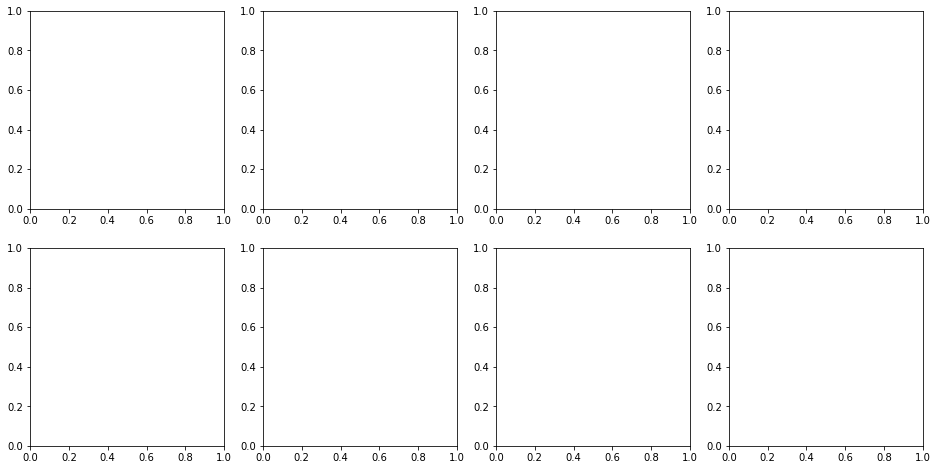

In [5]:
fig, axs = plt.subplots(2, 4, figsize=(16, 8))
plot_idx = 1
for i in range(4):
    msk = masks[plot_idx, i]
    recon = recons[plot_idx, i]
    axs[1, i].imshow(msk)
    axs[0, i].imshow(recon)
    

    axs[0][i].set_title(f"Slot reconstruction {i}")
    axs[1][i].set_title(f"Alpha Mask {i}")

plt.show()

fig, axs = plt.subplots(1, 3, figsize=(16, 8))
axs[0].imshow(images.squeeze(0).cpu().numpy()[plot_idx].transpose(1, 2, 0))
axs[0].set_title("Input Image")

axs[1].imshow(flows.squeeze(0).cpu().numpy()[plot_idx].transpose(1, 2, 0))
axs[1].set_title("Ground Truth Flow")

axs[2].imshow(recon_all[plot_idx].transpose(1, 2, 0))
axs[2].set_title("Predicted Flow")

plt.show()